In [1]:
import numpy as np
import time
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

___

Power Iteration implemented using MPI4Py

In [2]:
!python power_method.py --help

usage: power_method.py [-h] [-m MATRIX] [-i ITER] [-v VERBOSE] [-np NUMPY]
                       [-s SAVE]

optional arguments:
  -h, --help            show this help message and exit
  -m MATRIX, --matrix MATRIX
                        square matrix size (Default: 100)
  -i ITER, --iter ITER  number of Iterations for Power Method (Default: 10000)
  -v VERBOSE, --verbose VERBOSE
                        verbose (0, 1, 2) (Default: 2)
  -np NUMPY, --numpy NUMPY
                        use Numpy (default: 1)
  -s SAVE, --save SAVE  save to file (default: None)


___

Comparison with Numpy

In [3]:
def generate_matrix(dim):
    from scipy.stats import ortho_group
    from scipy.sparse import spdiags
    a = ortho_group.rvs(dim, random_state=0)
    b = np.linspace(1., 10., dim)
    return a @ spdiags(b, 0, dim, dim) @ a.T

def power_iter(A, sims):
    
    start_time = time.time()
    b = np.random.rand(A.shape[1])

    for _ in range(simul):
        
        Ab_i = A @ b
        Ab_norm_i = np.linalg.norm(Ab_i)
        b = Ab_i / Ab_norm_i
        
    runtime = time.time() - start_time
    return dict(eigenval=b, runtime=runtime)

___

### Sample execution:

In [4]:
!mpiexec -n 5 python power_method.py -m 500 -i 10000 -v 1 -v 1

Rank 0:
- Total Runtime:     0.27 Secs.


In [5]:
!mpiexec -n 5 python power_method.py -m 500 -i 10000 -v 2

Processes:	5
Matrix Size:	500
Iterations:	10,000
Rank 0:
- Total Runtime:     0.24 Secs.
> Est. eigenvalue:   9.999999999999908
> Est. eigenvector:  [ 0.11086445 -0.04502553 -0.0168605   0.02912957  0.03294897]... (Total length: 500)
> Real eigenvalue:    9.999999999999993
> Real eigenvector:  [-0.11086428  0.04502556  0.01686045 -0.0291296  -0.03294908]... (Total length: 500)
- Error: -8.53e-14 | % Error: -8.53e-15%


___

### Numpy Vs No Numpy runtime example

In [6]:
!mpiexec -n 5 python power_method.py -m 500 -i 2000 -v 1 -np 1
!mpiexec -n 5 python power_method.py -m 500 -i 2000 -v 1 -np 0

Rank 0:
- Total Runtime:     0.05 Secs.
Rank 0:
- Total Runtime:    48.03 Secs.


### Benchmark Error - Estimated vs Real

In [7]:
!mpiexec -n 6 python power_method.py -m 1800 -i 5 -v 0 --save bench_error
!mpiexec -n 6 python power_method.py -m 1800 -i 10 -v 0 --save bench_error
!mpiexec -n 6 python power_method.py -m 1800 -i 50 -v 0 --save bench_error
!mpiexec -n 6 python power_method.py -m 1800 -i 100 -v 0 --save bench_error
!mpiexec -n 6 python power_method.py -m 1800 -i 500 -v 0 --save bench_error
!mpiexec -n 6 python power_method.py -m 1800 -i 1000 -v 0 --save bench_error
!mpiexec -n 6 python power_method.py -m 1800 -i 5000 -v 0 --save bench_error
!mpiexec -n 6 python power_method.py -m 1800 -i 10000 -v 0 --save bench_error

In [8]:
bench_error = pd.read_csv('bench_error.csv')
bench_error['Abs. Error'] = abs(bench_error['Error'])

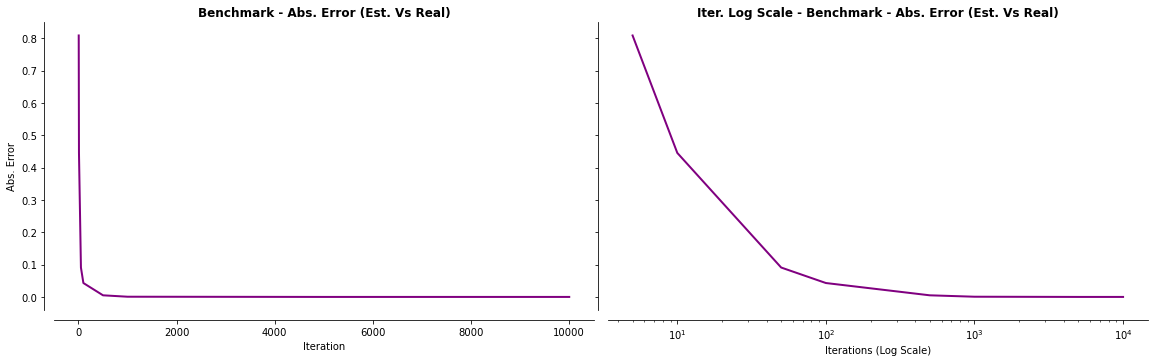

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
sns.lineplot(data=bench_error, x='Iteration', y='Abs. Error', color='purple',
             linewidth=2, ax=ax[0])
ax[0].set_title("Benchmark - Abs. Error (Est. Vs Real)", weight='bold')
sns.lineplot(data=bench_error, x='Iteration', y='Abs. Error', color='purple',
             linewidth=2, ax=ax[1])
ax[1].set_title("Iter. Log Scale - Benchmark - Abs. Error (Est. Vs Real)", weight='bold')
ax[1].set_xscale('log')
ax[1].set_xlabel('Iterations (Log Scale)')
plt.tight_layout()
sns.despine(offset=10)

### Benchmark Runtimes

In [10]:
A = generate_matrix(1800)
simul = 10000
local_result = power_iter(A, simul)

In [11]:
!mpiexec -n 1 python power_method.py -m 1800 -i 10000 -v 0 --save runtime
!mpiexec -n 2 python power_method.py -m 1800 -i 10000 -v 0 --save runtime
!mpiexec -n 3 python power_method.py -m 1800 -i 10000 -v 0 --save runtime
!mpiexec -n 4 python power_method.py -m 1800 -i 10000 -v 0 --save runtime
!mpiexec -n 5 python power_method.py -m 1800 -i 10000 -v 0 --save runtime
!mpiexec -n 6 python power_method.py -m 1800 -i 10000 -v 0 --save runtime
!mpiexec -n 8 python power_method.py -m 1800 -i 10000 -v 0 --save runtime

In [12]:
runtime = pd.read_csv('runtime.csv')

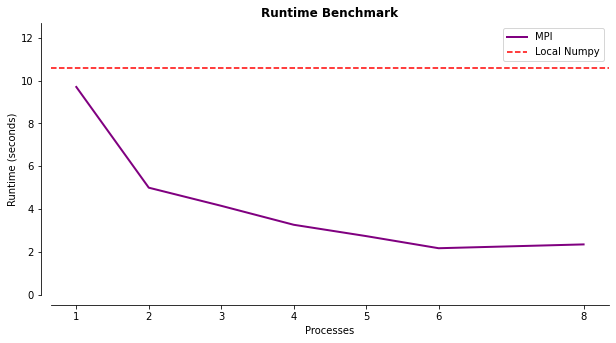

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=runtime, x='Processes', y='Runtime', ax=ax, label='MPI',
            linewidth=2, color='purple')
ax.axhline(local_result['runtime'], color='r', label='Local Numpy',
           linestyle='--')
ax.set_ylim(0, max([runtime['Runtime'].max(), local_result['runtime']]) * 1.2)
ax.set_xticks(runtime['Processes'])
ax.set_title('Runtime Benchmark', weight='bold')
ax.set_ylabel('Runtime (seconds)')
ax.legend()
sns.despine(offset=10)
plt.show()

___

## DataFrames

#### Benchmark Error

In [14]:
bench_error

,Name,Processes,Cols,Iteration,Runtime,Est_Eigenvalue,Real_Eigenvalue,Error,Pct_Error,Abs. Error
0,bench_error,6,1800,5,0.012511,9.191264,10.0,-8.087363e-01,-8.087363e-02,8.087363e-01
1,bench_error,6,1800,10,0.013011,9.554569,10.0,-4.454315e-01,-4.454315e-02,4.454315e-01
2,bench_error,6,1800,50,0.038533,9.909055,10.0,-9.094459e-02,-9.094459e-03,9.094459e-02
3,bench_error,6,1800,100,0.034031,9.957004,10.0,-4.299626e-02,-4.299626e-03,4.299626e-02
4,bench_error,6,1800,500,0.182158,9.995004,10.0,-4.996105e-03,-4.996105e-04,4.996105e-03
5,bench_error,6,1800,1000,0.260226,9.999366,10.0,-6.342350e-04,-6.342350e-05,6.342350e-04
6,bench_error,6,1800,5000,1.125468,10.000000,10.0,-3.700790e-07,-3.700790e-08,3.700790e-07
7,bench_error,6,1800,10000,2.321000,10.000000,10.0,-2.376170e-09,-2.376170e-10,2.376170e-09


#### Runtime

In [15]:
runtime

,Name,Processes,Cols,Iteration,Runtime,Est_Eigenvalue,Real_Eigenvalue,Error,Pct_Error
0,runtime,1,1800,10000,9.700341,10.0,10.0,-2.376170e-09,-2.376170e-10
1,runtime,2,1800,10000,4.999300,10.0,10.0,-2.376170e-09,-2.376170e-10
2,runtime,3,1800,10000,4.152573,10.0,10.0,-2.376170e-09,-2.376170e-10
3,runtime,4,1800,10000,3.268309,10.0,10.0,-2.376170e-09,-2.376170e-10
4,runtime,5,1800,10000,2.739359,10.0,10.0,-2.376170e-09,-2.376170e-10
5,runtime,6,1800,10000,2.173870,10.0,10.0,-2.376170e-09,-2.376170e-10
6,runtime,8,1800,10000,2.352024,10.0,10.0,-2.376169e-09,-2.376169e-10


### Mini-Benchmark - No Numpy

In [16]:
!mpiexec -n 1 python power_method.py -m 384 -i 1000 -v 0 -np 0 --save rtime_no_np
!mpiexec -n 2 python power_method.py -m 384 -i 1000 -v 0 -np 0 --save rtime_no_np
!mpiexec -n 4 python power_method.py -m 384 -i 1000 -v 0 -np 0 --save rtime_no_np
!mpiexec -n 6 python power_method.py -m 384 -i 1000 -v 0 -np 0 --save rtime_no_np
!mpiexec -n 8 python power_method.py -m 384 -i 1000 -v 0 -np 0 --save rtime_no_np

In [17]:
rtime_no_np = pd.read_csv('rtime_no_np.csv')
os.remove('rtime_no_np.csv')

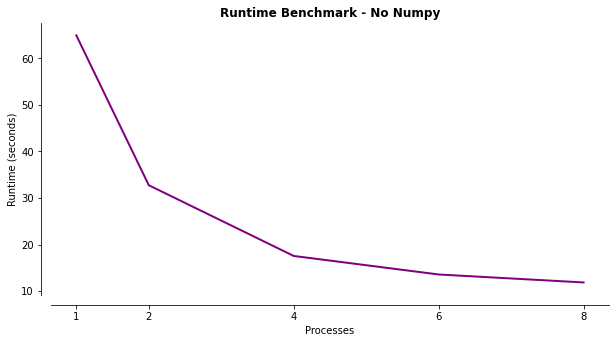

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=rtime_no_np, x='Processes', y='Runtime', ax=ax,
            linewidth=2, color='purple')
ax.set_xticks(rtime_no_np['Processes'])
ax.set_title('Runtime Benchmark - No Numpy', weight='bold')
ax.set_ylabel('Runtime (seconds)')
sns.despine(offset=10)
plt.show()